# Nonsolobaschet Stats | 2018

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
# Set the style globally
plt.style.use('default')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Exo 2'
rcParams['font.weight'] = '500'
#rcParams['font.monospace'] = 'Ubuntu Mono'
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 16
rcParams['axes.labelweight'] = '500'
rcParams['axes.titleweight'] = '600'
rcParams['axes.titlesize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['legend.fontsize'] = 12
rcParams['figure.titlesize'] = 18


### Init dataframes #########################################################
Teams = {'gianluca' : ['La mamma di Enrico', 'midnightblue'],
         'fabio' : ['Porti Chiusi Italiani', 'yellowgreen'],
         'enrico' : ['Gianlucanonpressare', 'darkorange'],
         'gabriele' : ['Sciagura', 'r'],
         'luca' : ['Nottingham Forrest Gump', 'lightskyblue'],
         'ale' : ['Sanfa','seagreen']
        }

parameters = [
    'punti_fatti',         # fantapunti realizzati
    'punti_subiti',        # fantapunti subiti
    'goal_subiti_por',     # goal subiti dal portiere che concorre a punteggio squadra
    'cartellini',          # subiti da giocatori che concorrono a punteggio squadra (giallo=1, rosso=2)
    #'bonus_panchina',      # somma dei bonus giocatori che non concorrono a punteggio squadra
    'mod_difesa',          # modificatore difesa
    #'mod_fairplay'         # modificatore fairplay
]
df = pd.DataFrame(columns=parameters)

df_gianluca = df
df_fabio = df
df_enrico = df
df_gabriele = df
df_luca = df
df_ale = df

Results = {
    'gianluca' : df_gianluca,
    'fabio' : df_fabio,
    'enrico' : df_enrico,
    'gabriele' : df_gabriele,
    'luca' : df_luca,
    'ale' : df_ale
}

# Steps of scored goals, number of players, own goal, low scoring
goal_marks=np.array([66,71,76,81,86,91,96,101,106])
step=5
n_giocatori=len(Teams)
soglia_autogol=58
low_score=62

### Utility functions ################################################
def get_goal(fp,fpsub):
    '''Return number of goals given fantapoints'''
    goal_counter = 0
    if fpsub < soglia_autogol: goal_counter = goal_counter+1
    for mark in goal_marks:
        if fp<mark: return goal_counter
        goal_counter = goal_counter+1
    return goal_counter

def pti_guadagnati_diff(fp,fpsub,pti):
    '''Ritorna guadagno in punti rispetto al valore atteso data la differenza in fantapunti'''
    diff=fp-fpsub
    if diff <-step:
        exp_pti=0
    elif diff >=step:
        exp_pti=3
    elif diff >=-step and diff<0:
        exp_pti=1+diff/step
    elif diff >=0 and diff<step:
        exp_pti=1+2*diff/step
    return pti-exp_pti 
    
def esito(gf,gs):
    '''Return match result (V,P,S) given goal scored and conceded'''
    if gf>gs: return 'V'
    elif gf<gs: return 'S'
    else: return 'P'
    
def punti(esito):
    '''Return standing points given match result'''
    try:
        if esito=='V': return 3
        elif esito=='S': return 0
        elif esito=='P': return 1
    except ValueError:
        print('Esito non valido')

#def mod_fairplay(cartellini):
#    '''Return modificatore fairplay value given number of yellow/red cards'''
#    if cartellini==0: return 1
#    return 0

def get_team_colors():
    '''Return list of team colors by default order'''
    colors = []
    for key in Teams.keys():
        colors.append(Teams[key][1])
    return colors
    
def fattore_distacco(Total):
    pf_med = np.median(Total['punti_fatti'])
    pf_std = np.std(Total['punti_fatti'])
    dist_med = np.median(Total['distacco'])
    dist_std = np.std(Total['distacco'])
    pf_rel = (Total['punti_fatti'] - pf_med) / pf_std
    dist_rel = (Total['distacco'] - dist_med) / dist_std
    return -dist_rel-pf_rel

def calc_fortuna(df):
    keys = ('f_pos', 'f_distacco', 'f_GS', 'f_close_games')
    scaling = (0.5, 1, 1, 0.5)
    cols = ['dodgerblue', 'purple', 'r', 'gold']
    factors = []
    df['IndiceFortuna'] = [0,0,0,0,0,0,0,0]
    ### build fortuna
    for col,scale in zip(keys,scaling):
        factors.append(df[col]*scale)
        df['IndiceFortuna'] = df['IndiceFortuna'] + df[col]*scale
    return df

# >>> Scores txt files <<<

### Gianluca | La mamma di Enrico

In [8]:
%%writefile gianluca.txt
gg pf ps gs c mdif
1 82 77.5 1 1 1
2 63.5 67 1 3 0

Overwriting gianluca.txt


### Fabio | Porti Chiusi Italiani

In [9]:
%%writefile fabio.txt
gg pf ps gs c mdif
1 77 72 3 3 0
2 67.5 57.5 1 2 0

Overwriting fabio.txt


### Enrico | Gianlucanonpressare

In [10]:
%%writefile enrico.txt
gg pf ps gs c mdif
1 79.5 61 1 2 3
2 57.5 67.5 2 4 0

Overwriting enrico.txt


### Gabriele | Sciagura

In [11]:
%%writefile gabriele.txt
gg pf ps gs c mdif
1 72 77 0 1 1
2 72 74.5 0 3 3

Overwriting gabriele.txt


### Luca | Nottingham Forrest Gump

In [12]:
%%writefile luca.txt
gg pf ps gs c mdif
1 77.5 82 0 1 3
2 74.5 72 2 1 1

Overwriting luca.txt


### Ale | Sanfa

In [13]:
%%writefile ale.txt
gg pf ps gs c mdif
1 61 79.5 2 1 0
2 67 63.5 1 0 0

Overwriting ale.txt


# >>> Fill dataframes <<<

In [16]:
### Fill dataframe per partita #############################
for team, df in Results.items():
    Results[team] = Results[team][0:0]
    Results[team] = pd.read_csv(team+'.txt', sep=' ', names=parameters, skiprows=1)
    Results[team]['GF'] = Results[team].apply(lambda x: get_goal(x['punti_fatti'],x['punti_subiti']), axis=1)
    Results[team]['GS'] = Results[team].apply(lambda x: get_goal(x['punti_subiti'],x['punti_fatti']), axis=1)
    Results[team]['esito'] = Results[team].apply(lambda x: esito(x['GF'],x['GS']), axis=1)
    Results[team]['pti'] = Results[team].apply(lambda x: punti(x['esito']), axis=1)
    Results[team] = Results[team].assign(Team=team)
    Results[team]['f_close_games'] = Results[team].apply(lambda x: pti_guadagnati_diff(x['punti_fatti'],x['punti_subiti'],x['pti']), axis=1)
    
       
### Global variables #############################
giornate = max(Results[list(Teams.keys())[0]].index)

### concatenate team dataframes ##################
cdf = pd.concat(Results)
pf_mean = np.mean(cdf.punti_fatti)
pf_med = np.median(cdf.punti_fatti)
pf_std = np.std(cdf.punti_fatti)
ps_med = np.median(cdf.punti_subiti)
ps_std = np.std(cdf.punti_subiti)
gf_mean = np.mean(cdf.GF)
gf_med = np.median(cdf.GF)
gf_std = np.std(cdf.GF)
print('### CUMULATIVE DATA after', giornate, 'rounds ###')
print('Punti Fatti:\n media =', pf_mean, '\n mediana =', pf_med, '\n varianza =', pf_std, 
      #'\nPunti Subiti:\n mediana =', ps_med, '\n varianza =', ps_std, 
      '\nGoal Fatti:\n media =', gf_mean, '\n mediana =', gf_med, '\n varianza =', gf_std
     )
#display(cdf)
#cdf.index
    
media_personale={}
for team, new_df in cdf.groupby(level=0):
    media_personale[team]=np.mean(new_df.punti_fatti)
    
print('\n Medie personali:')
display(media_personale)
    
def pti_guadagnati_media(gf,pti,giornata):
    '''Ritorna guadagno in punti rispetto al valore atteso considerando i goal fatti dagli altri giocatori, in quella giornata'''
    exp_pti=0
    for team in Teams.keys():
        exp_pti=exp_pti+punti(esito(gf,Results[team].at[giornata,'GF']))
    return pti-(exp_pti-1)/(n_giocatori-1)  # -1 per eliminare il caso di essere contro sé stessi

def pti_guadagnati_mediaP(gs,pti,team,giornata):
    '''Ritorna guadagno in punti rispetto al valore atteso considerando i goal fatti dal giocatore nelle giornate precedenti'''
    exp_pti=0
    for g in range(1, giornata):
        exp_pti=exp_pti+punti(esito(Results[team].at[g,'GF'],gs))
    return pti-exp_pti/(giornata-1)

for team, df in Results.items():
    #Results[team]['f_media_giornata']=0
    for g in range(1,giornate+1):
        Results[team].at[g,'f_media_giornata'] = pti_guadagnati_media(Results[team].at[g,'GF'],Results[team].at[g,'pti'],g)
    Results[team].at[1,'f_media_personale'] = 0
    for g in range(2,giornate+1):
        Results[team].at[g,'f_media_personale'] = pti_guadagnati_mediaP(Results[team].at[g,'GS'],Results[team].at[g,'pti'],team,g)
    
    print('###', team, '|', Teams[team][0], '###')
    display(Results[team])
    print('\n\n\n')

### CUMULATIVE DATA after 2 rounds ###
Punti Fatti:
 media = 70.91666666666667 
 mediana = 72.0 
 varianza = 7.373469709407883 
Goal Fatti:
 media = 1.8333333333333333 
 mediana = 2.0 
 varianza = 1.2801909579781015

 Medie personali:


{'ale': 64.0,
 'enrico': 68.5,
 'fabio': 72.25,
 'gabriele': 72.0,
 'gianluca': 72.75,
 'luca': 76.0}

### gianluca | La mamma di Enrico ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,mod_difesa,GF,GS,esito,pti,Team,f_close_games,f_media_giornata,f_media_personale
1,82.0,77.5,1,1,1,4,3,V,3,gianluca,0.2,0.0,0.0
2,63.5,67.0,1,3,0,0,1,S,0,gianluca,-0.3,-0.2,-3.0






### fabio | Porti Chiusi Italiani ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,mod_difesa,GF,GS,esito,pti,Team,f_close_games,f_media_giornata,f_media_personale
1,77.0,72.0,3,3,0,3,2,V,3,fabio,0,1.4,0.0
2,67.5,57.5,1,2,0,2,0,V,3,fabio,0,0.8,0.0






### enrico | Gianlucanonpressare ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,mod_difesa,GF,GS,esito,pti,Team,f_close_games,f_media_giornata,f_media_personale
1,79.5,61.0,1,2,3,3,0,V,3,enrico,0,1.4,0.0
2,57.5,67.5,2,4,0,0,2,S,0,enrico,0,-0.2,-3.0






### gabriele | Sciagura ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,mod_difesa,GF,GS,esito,pti,Team,f_close_games,f_media_giornata,f_media_personale
1,72,77.0,0,1,1,2,3,S,0,gabriele,0.0,-0.6,0.0
2,72,74.5,0,3,3,2,2,P,1,gabriele,0.5,-1.2,0.0






### luca | Nottingham Forrest Gump ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,mod_difesa,GF,GS,esito,pti,Team,f_close_games,f_media_giornata,f_media_personale
1,77.5,82,0,1,3,3,4,S,0,luca,-0.1,-1.6,0.0
2,74.5,72,2,1,1,2,2,P,1,luca,-1.0,-1.2,-2.0






### ale | Sanfa ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,mod_difesa,GF,GS,esito,pti,Team,f_close_games,f_media_giornata,f_media_personale
1,61,79.5,2,1,0,0,3,S,0,ale,0.0,0.0,0.0
2,67,63.5,1,0,0,1,0,V,3,ale,0.6,1.8,2.0


In [17]:
### Total values dataframe #######################
def low_scoring_games(verbose=False, data=Results, giornate=max(Results[list(Teams.keys())[0]].index)):
    '''Compute close games per team and add factor to Total dataframe'''
    factor_low_scoring_games = []
    for team, df in data.items():
        df = df[df.index <= giornate]
        if verbose: print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if df['punti_fatti'][gg] < low_score:
                res = esito(df.GF[gg], df.GS[gg])
                if verbose: print('G', gg, '| punti fatti:', df.punti_fatti[gg], ' ( subiti:', df.punti_subiti[gg],') |', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        try:
            if verbose: print('---> %d punti in %d giornate \n     (media: %.2f)' % (pti, g, pti/g))
            factor_close_games.append(pti-g)
        except:
            if verbose: print('---> No games found')
            factor_close_games.append(0)
    return factor_low_scoring_games


def expected_punti(verbose=False, data=Results, giornate=max(Results[list(Teams.keys())[0]].index)):
    '''Compute expected punti and add factor to Total dataframe'''
    factor = []
    for team, df in data.items():
        df = df[df.index <= giornate]
        if verbose: print('\n###', team, '###')
        pti_guadagnati=0
        g=0
        for gg in df.index:
            diff=df['punti_fatti'][gg]-df['punti_subiti'][gg]
            res = esito(df.GF[gg], df.GS[gg])
            pti=punti(res)
            if diff <-step:
                exp_pti=0
            elif diff >=step:
                exp_pti=3
            elif diff >=-step and diff<0:
                exp_pti=1+diff/step
            elif diff >=0 and diff<step:
                exp_pti=1+2*diff/step
            pti_guadagnati=pti_guadagnati+pti-exp_pti
            if (pti-exp_pti)!=0:
                g=g+1
                if verbose: print('G', gg, '| punti fatti:', df.punti_fatti[gg], ' ( subiti:', df.punti_subiti[gg],') |', res, '(', df.GF[gg], '-', df.GS[gg], ') | guadagnati: %.1f' % (pti-exp_pti))                
        factor.append(pti_guadagnati)
        try:
            if verbose: print('---> %.1f punti guadagnati in %d giornate' % (pti_guadagnati, g))
        except:
            if verbose: print('---> Nessuna partita con differenza <', step)
    return factor
    

def make_Total_df(data=Results, giornate=max(Results[list(Teams.keys())[0]].index)):
    columns = list(data[list(Teams.keys())[0]])
    table = [[]]
    for team,df in data.items():
        df = df[df.index <= giornate]
        values = []
        for col in columns:
            values.append(df[col].sum())
        values[len(values)-4]=team
        table.append(values)
    table=table[1:]
    Total=pd.DataFrame(table,columns=columns)
    # additional columns
    Total = Total.sort_values(by=['punti_fatti'], ascending=False)
    Total['pos'] = Total['pti'].rank(ascending=False, method='first')
    Total['rank'] = Total['punti_fatti'].rank(ascending=False, method='first')
    Total['distacco'] = np.max(Total['pti']) - Total['pti']
    Total['f_pos'] = Total['rank']-Total['pos'] #(posizione fantapunti)-(posizione punti)
    Total['f_distacco'] = fattore_distacco(Total)
    Total['x_punti_subiti'] = (Total['punti_fatti'].sum() - Total['punti_fatti'])/(n_giocatori-1)
    Total['x_GS'] = (Total['GF'].sum() - Total['GF'])/(n_giocatori-1) #valore atteso di gol subiti mediamente affrontando gli altri n-1
    Total['f_GS'] = -1*(Total['GS']-Total['x_GS'])/np.std(Total['GS'])
    Total.sort_index(inplace=True)
    #Total['f_stolen_games'] = exact_fp(giornate=giornate)
    #Total['f_unlucky_opponent'] = opponent_almost_scored(giornate=giornate)
    return Total

#build full Total dataframe
print('... Filling Total df ...')
Total = make_Total_df()

#Mostra dataframe totale ordinato secondo la classifica
Total2=Total.set_index('Team')
Total2.sort_values(by=['pti', 'punti_fatti'], inplace=True, ascending=False)
print('### Dati cumulati dopo', giornate, 'giornate ###')
display(Total2)


#Dataframe per i risultati dell'ultima giornata
cdf = pd.concat(Results)
print('\n### Dati giornata numero ', giornate, ' ###')
cdf_g=cdf.xs(giornate, level=1)
cdf_g.set_index('Team', inplace=True)
display(cdf_g)


... Filling Total df ...
### Dati cumulati dopo 2 giornate ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,mod_difesa,GF,GS,esito,pti,f_close_games,f_media_giornata,f_media_personale,pos,rank,distacco,f_pos,f_distacco,x_punti_subiti,x_GS,f_GS
Team,,,,,,,,,,,,,,,,,,,,
fabio,144.5,129.5,4,5,0,5,2,VV,6,0.0,2.2,0.0,1.0,3.0,0,2.0,1.758018,141.3,3.4,0.939149
gianluca,145.5,144.5,2,4,1,4,4,VS,3,-0.1,-0.2,-3.0,2.0,2.0,3,0.0,-0.165245,141.1,3.6,-0.268328
enrico,137.0,128.5,3,6,3,3,2,VS,3,0.0,1.2,-3.0,3.0,5.0,3,2.0,0.958420,142.8,3.8,1.207477
ale,128.0,143.0,3,1,0,1,3,SV,3,0.6,1.8,2.0,4.0,6.0,3,2.0,2.148182,144.6,4.2,0.804984
luca,152.0,154.0,2,2,4,5,6,SP,1,-1.1,-2.8,-2.0,5.0,1.0,5,-4.0,-2.218562,139.8,3.4,-1.744133
gabriele,144.0,151.5,0,4,4,4,5,SP,1,0.5,-1.8,0.0,6.0,4.0,5,-2.0,-1.160996,141.4,3.6,-0.939149



### Dati giornata numero  2  ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,mod_difesa,GF,GS,esito,pti,f_close_games,f_media_giornata,f_media_personale
Team,,,,,,,,,,,,
ale,67.0,63.5,1,0,0,1,0,V,3,0.6,1.8,2.0
enrico,57.5,67.5,2,4,0,0,2,S,0,0.0,-0.2,-3.0
fabio,67.5,57.5,1,2,0,2,0,V,3,0.0,0.8,0.0
gabriele,72.0,74.5,0,3,3,2,2,P,1,0.5,-1.2,0.0
gianluca,63.5,67.0,1,3,0,0,1,S,0,-0.3,-0.2,-3.0
luca,74.5,72.0,2,1,1,2,2,P,1,-1.0,-1.2,-2.0


# [>] Expected Punti/Goal Subiti

C:\Users\Luca\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Luca\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Luca\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Luca\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


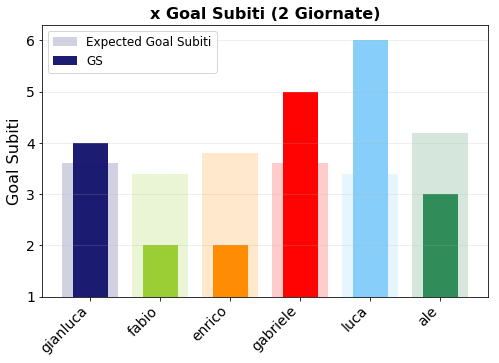

In [18]:
fig = plt.figure(figsize=(8,5))

colors = get_team_colors()

plt.bar(np.arange(0,n_giocatori), Total['x_GS'], color=colors, alpha=0.2, label='Expected Goal Subiti')
plt.bar(np.arange(0,n_giocatori), Total['GS'], color=colors, alpha=0.99, width=0.5, label='GS')
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.grid(which='both', axis='y', alpha=0.25)

plt.ylim(bottom = min(Total['GS']-1))
plt.ylabel('Goal Subiti')
title = 'x Goal Subiti (' + str(giornate) + ' Giornate)'
plt.title(title)

plt.legend()

plt.show()

C:\Users\Luca\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


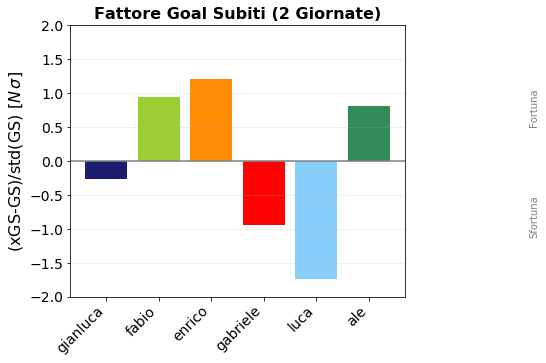

In [19]:
fig = plt.figure(figsize=(6,5))
plt.grid(which='both', axis='y', ls='-', alpha=0.25)

colors = get_team_colors()

std = np.std(Total['GS'])
plt.bar(np.arange(0,n_giocatori), -1*(Total['GS']-Total['x_GS'])/std, color=colors, alpha=0.99, width=0.8, label='Fattore GS')
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')
plt.ylim(-2,2)

plt.ylabel('(xGS-GS)/std(GS) [$N\,\sigma$]')
title = 'Fattore Goal Subiti (' + str(giornate) + ' Giornate)'
plt.title(title)

plt.text(x=8.25, y=+0.5, s='Fortuna', verticalalignment='bottom', horizontalalignment='right', color='grey', rotation='90')
plt.text(x=8.25, y=-0.5, s='Sfortuna', verticalalignment='top', horizontalalignment='right', color='grey', rotation='90')


#plt.legend()

plt.show()

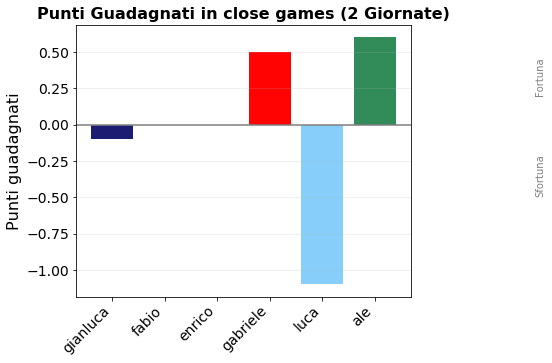

In [20]:
fig = plt.figure(figsize=(6,5))
plt.grid(which='both', axis='y', ls='-', alpha=0.25)

colors = get_team_colors()

xlabels = Total['Team']
plt.bar(np.arange(0,n_giocatori), Total['f_close_games'], color=colors, alpha=0.99, width=0.8, label='Punti guadagnati')

plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')
ylim = np.max(np.abs(Total['f_close_games']))*1.3

plt.ylabel('Punti guadagnati')
title = 'Punti Guadagnati in close games (' + str(giornate) + ' Giornate)'
plt.title(title)

plt.text(x=8.25, y=+0.2, s='Fortuna', verticalalignment='bottom', horizontalalignment='right', color='grey', rotation='90')
plt.text(x=8.25, y=-0.2, s='Sfortuna', verticalalignment='top', horizontalalignment='right', color='grey', rotation='90')


#plt.legend()

plt.show()

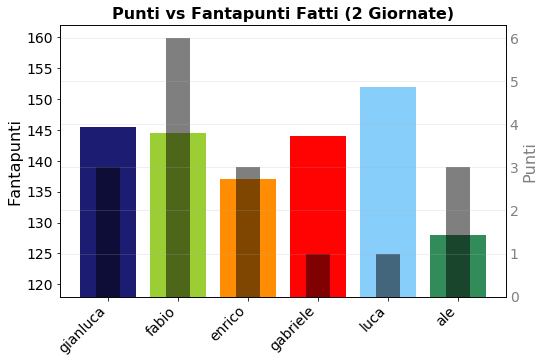

In [21]:
### Punti fatti vs classifica ###############
fig = plt.figure(figsize=(8,5))

colors = get_team_colors()
x = Total['punti_fatti']
y = Total['pti']

plt.bar(np.arange(0,n_giocatori), x, color=colors, alpha=0.99, label='Expected Goal Subiti')
plt.ylabel('Fantapunti')
plt.ylim(np.min(x)-10, np.max(x)+10)
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')

# secondary y axis
ax2 = plt.twinx()
ax2.set_ylabel('Fantapunti')
ax2.tick_params(axis='y', colors='grey', length=0)
ax2.yaxis.label.set_color('grey')
ax2.plot([],[])

plt.bar(np.arange(0,n_giocatori), y, color='black', alpha=0.5, width=0.35, label='GS')


#plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.grid(which='both', axis='y', alpha=0.25)

#plt.ylim(ymin = min(Total['GS']-1))
plt.ylabel('Punti')
title = 'Punti vs Fantapunti Fatti (' + str(giornate) + ' Giornate)'
plt.title(title)

#plt.legend()

plt.show()

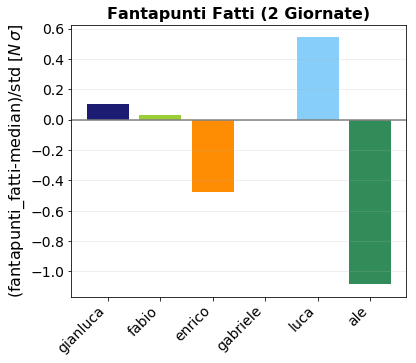

In [22]:
fig = plt.figure(figsize=(6,5))
plt.grid(which='both', axis='y', ls='-', alpha = 0.25)

colors = get_team_colors()
    
std = pf_std*giornate
med = pf_med*giornate

plt.bar(np.arange(0,n_giocatori), (Total['punti_fatti']-med)/std, color=colors, alpha=0.99, width=0.8, label='')
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')
#plt.ylim(-2,2)


plt.ylabel('(fantapunti_fatti-median)/std [$N\,\sigma$]')
title = 'Fantapunti Fatti (' + str(giornate) + ' Giornate)'
plt.title(title)

plt.show()

# [>] Close games

In [23]:
#### Expected punti per partite con differenza fantapunti <5 ######
expected_punti(verbose=True)


### gianluca ###
G 1 | punti fatti: 82.0  ( subiti: 77.5 ) | V ( 4 - 3 ) | guadagnati: 0.2
G 2 | punti fatti: 63.5  ( subiti: 67.0 ) | S ( 0 - 1 ) | guadagnati: -0.3
---> -0.1 punti guadagnati in 2 giornate

### fabio ###
---> 0.0 punti guadagnati in 0 giornate

### enrico ###
---> 0.0 punti guadagnati in 0 giornate

### gabriele ###
G 2 | punti fatti: 72  ( subiti: 74.5 ) | P ( 2 - 2 ) | guadagnati: 0.5
---> 0.5 punti guadagnati in 1 giornate

### luca ###
G 1 | punti fatti: 77.5  ( subiti: 82 ) | S ( 3 - 4 ) | guadagnati: -0.1
G 2 | punti fatti: 74.5  ( subiti: 72 ) | P ( 2 - 2 ) | guadagnati: -1.0
---> -1.1 punti guadagnati in 2 giornate

### ale ###
G 2 | punti fatti: 67  ( subiti: 63.5 ) | V ( 1 - 0 ) | guadagnati: 0.6
---> 0.6 punti guadagnati in 1 giornate


[-0.09999999999999987, 0, 0, 0.5, -1.1, 0.6000000000000001]

# <<<<< Indice Fortuna >>>>>

In [24]:
def get_bigradient_colors():
    colors = []
    edgecolors = []
    for key in Teams.keys():
        x = Total[Total['Team']==key]['IndiceFortuna'].sum()
        if Total[Total['Team']==key]['IndiceFortuna'].sum() >= 0:
            x = (max_f - Total[Total['Team']==key]['IndiceFortuna'].sum())/max_f
            s = (x,1,x)
            colors.append(s)
            edgecolors.append('g')
            #edgecolors.append('limegreen')
        else: 
            x = -(Total[Total['Team']==key]['IndiceFortuna'].sum() - min_f)/min_f
            s=(1,x,x)
            colors.append(s)
            #edgecolors.append('orangered')
            edgecolors.append('r')
    return colors, edgecolors

# Take negative and positive data apart and cumulate
def get_cumulated_array(data, **kwargs):
    cum = data.clip(**kwargs)
    cum = np.cumsum(cum, axis=0)
    d = np.zeros(np.shape(data))
    d[1:] = cum[:-1]
    return d 


tot_giornate = 28

keys = ('f_close_games', 'f_media_giornata', 'f_media_personale')
#scaling = (0.5, 1, 1, 0.5, 0.25*tot_giornate/giornate, 0.25*tot_giornate/giornate, 0)
scaling = (1, 1, 1)

cols = ['dodgerblue', 'purple', 'r']

def calc_fortuna(df):
    factors = []
    df['IndiceFortuna'] = [0,0,0,0,0,0]
    ### build fortuna
    for col,scale in zip(keys,scaling):
        factors.append(df[col]*scale)
        df['IndiceFortuna'] = df['IndiceFortuna'] + df[col]*scale
    #print(len(factors))
    return df, factors


    


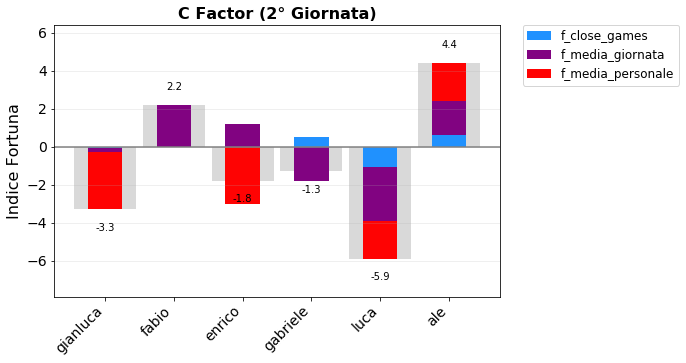

In [25]:
#--- Fortuna Total
Total, __factors__ = calc_fortuna(Total)
matchday = giornate
data_per_round = make_Total_df(giornate = matchday)
__df__, __factors__ = calc_fortuna(data_per_round)



# re-shape data for positive-negative bar plot
__data__ = np.array(__factors__)
#print(__data__)
data_shape = np.shape(__data__)
#print(data_shape)
cumulated_data = get_cumulated_array(__data__, min=0)
cumulated_data_neg = get_cumulated_array(__data__, max=0)
# Re-merge negative and positive data.
row_mask = (__data__<0)
cumulated_data[row_mask] = cumulated_data_neg[row_mask]
data_stack = cumulated_data
#print(np.shape(data_stack))



fig = plt.figure(figsize=(8,5))
plt.grid(which='major', axis='y', ls='-', alpha=0.25)
xlabels = __df__['Team']
plt.xticks(__df__.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')

max_f = max(__df__['IndiceFortuna'])
min_f = min(__df__['IndiceFortuna'])
colors, edgecolors = get_bigradient_colors()
plt.bar(np.arange(0,n_giocatori), __df__['IndiceFortuna'], color='black', edgecolor=edgecolors, lw=0, alpha=0.15, width=0.9, label='')

#print(np.arange(0, data_shape[0]))

for i in np.arange(0, data_shape[0]):
    plt.bar(np.arange(data_shape[1]), __data__[i], bottom=data_stack[i], color=cols[i],alpha=0.99, width=0.5, label=keys[i])
    
plt.legend()

for i, f in enumerate(list(np.round(__df__['IndiceFortuna'],decimals=1))):
    if f<0: 
        va = 'top'
        offset = -0.7
    else: 
        va = 'bottom'
        offset = 0.7
    plt.annotate(f, (i, f+offset), horizontalalignment='center', verticalalignment=va)
    
plt.ylim(min_f-2, max_f+2)

plt.ylabel('Indice Fortuna')
title = 'C Factor (' + str(matchday) + '° Giornata)'
plt.title(title)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



#Total.head(10)

C:\Users\Luca\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


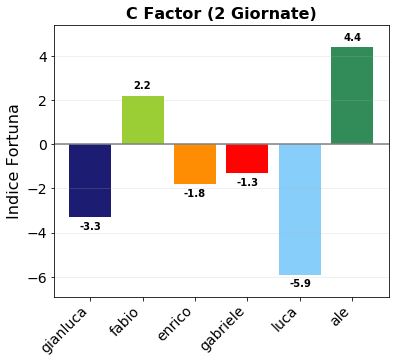

In [26]:
fig = plt.figure(figsize=(6,5))
plt.grid(which='major', axis='y', ls='-', alpha=0.25)
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')

max_f = max(Total['IndiceFortuna'])
min_f = min(Total['IndiceFortuna'])
colors = get_team_colors()
plt.bar(np.arange(0,n_giocatori), Total['IndiceFortuna'], color=colors, lw=0, alpha=0.99, width=0.8, label='')

for i, f in enumerate(list(np.round(Total['IndiceFortuna'],decimals=1))):
    if f<0: 
        va = 'top'
        offset = -0.2
    else: 
        va = 'bottom'
        offset = 0.2
    plt.annotate(f, (i, f+offset), horizontalalignment='center', verticalalignment=va, weight='bold')
    
plt.ylim(min_f-1, max_f+1)
plt.ylabel('Indice Fortuna')
title = 'C Factor (' + str(giornate) + ' Giornate)'
plt.title(title)
plt.show()

In [27]:
#--- build partial Total entries
print('... Filling Total df per round ...')
Tot_per_round = []
for gg in Results[list(Teams.keys())[0]].index:
    data_per_round = make_Total_df(giornate = gg)
    #print(data_per_round.dtypes)
    __df__, __factors__ = calc_fortuna(data_per_round)
    Tot_per_round.append(__df__)

... Filling Total df per round ...


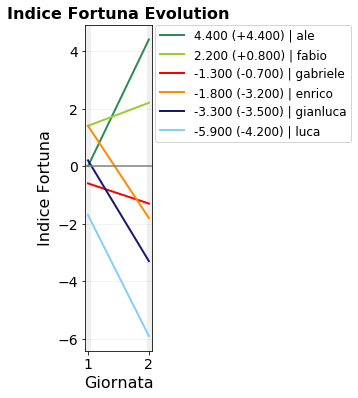

In [28]:
def fortuna_evo(title='Indice Fortuna Evolution', ylabel='Indice Fortuna'):

    giornate = Results[list(Teams.keys())[0]].index
    gg = max(giornate)
    fig = plt.figure(figsize=(gg*0.6,6))

    data = []
    for team in Teams.keys():
        dd = pd.DataFrame()
        score = 0
        scores = []
        for df in Tot_per_round:
            _ = df[df['Team'] == team]
            score = _['IndiceFortuna'].sum()
            #print(team, score)
            scores.append(score)
        dd['score'] = scores
        dd['Team'] = team
        data.append(dd)

    data = sorted(data,key=lambda x:x.at[gg-1,'score'].min(axis=0), reverse=True)

    for df in data:
        team = df['Team'].unique()[0]
        color = Teams[team][1]
        score = df.at[gg-1, 'score']
        score_prev = df.at[gg-2, 'score']
        diff = score - score_prev
        if diff > 0: sign='+'
        else: sign=''
        label = '%.3f (%s%.3f) | %s' % (score, sign, diff, team)
        p = plt.plot(giornate, df['score'], color=color, ls='-', lw=2, label=label)

    plt.xticks(np.arange(1,gg+1))
    plt.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
    plt.grid(axis='y', alpha=0.2)
    plt.axhline(0, color='grey')
    plt.xlabel('Giornata')
    plt.ylabel(ylabel)
    plt.title(title)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
fortuna_evo()

In [29]:
Tot_per_round[1].keys()

Index(['punti_fatti', 'punti_subiti', 'goal_subiti_por', 'cartellini',
       'mod_difesa', 'GF', 'GS', 'esito', 'pti', 'Team', 'f_close_games',
       'f_media_giornata', 'f_media_personale', 'pos', 'rank', 'distacco',
       'f_pos', 'f_distacco', 'x_punti_subiti', 'x_GS', 'f_GS',
       'IndiceFortuna'],
      dtype='object')

# [>] Premi Ignobel

In [30]:
 def premio_plot(par = 'goal_subiti_por', threshold=2, title='Premio Porta Violata "Mario Bruno"', ylabel='Goal subiti dal portiere'):
    giornate = Results[list(Teams.keys())[0]].index
    gg = max(giornate)
    fig = plt.figure(figsize=(gg*0.6,6))

    data = []
    for team, df in Results.items():
        df['cumsum'] = np.cumsum(df[par])
        score = max(df['cumsum'])
        df['score'] = score
        
        df_prev = df.drop(df.tail(1).index)         
        df_prev['cumsum_prev'] = np.cumsum(df_prev[par])
        score_prev = max(df_prev['cumsum'])
        df['score_prev'] = score_prev
        
        data.append(df)
    data = sorted(data,key=lambda x:x['score'].unique().min(axis=0), reverse=True)

    for df in data:
        team = df['Team'].unique()[0]
        color = Teams[team][1]
        df['cumsum'] = np.cumsum(df[par])
        score = max(df['cumsum'])
        score_prev = max(df['score_prev'])
        diff = score - score_prev
        p = plt.plot(giornate, df['cumsum'], color=color, ls='-', lw=2, label=str(score)+' (+'+str(diff)+') | '+str(team))
        #col = p[0].get_color()

        gior = df[df[par]>threshold].index
        dd = df[df.index.isin(gior)]
        marks = dd['cumsum']

        #cs = np.cumsum(dd[par])
        plt.scatter(gior, marks, edgecolor=color, facecolor=color, s=300+20*dd[par], label='')
        for x,y,text in zip(gior,marks,dd[par]):
            plt.text(x, y,text, horizontalalignment='center', verticalalignment='center', color='white')

    plt.xticks(np.arange(0,gg+1))
    plt.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
    plt.xlabel('Giornata')
    plt.ylabel(ylabel)
    plt.title(title, fontsize=20)

    plt.legend()
    plt.show()

C:\Users\Luca\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


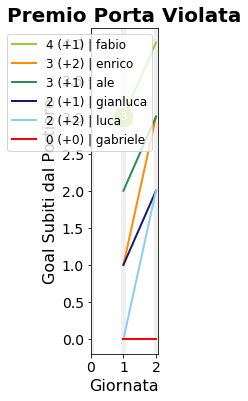

In [31]:
premio_plot(par='goal_subiti_por', title='Premio Porta Violata', ylabel='Goal Subiti dal Portiere')

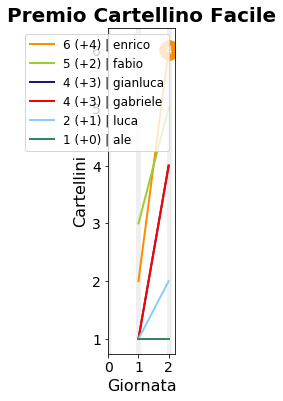

In [32]:
premio_plot(par='cartellini', threshold=3, title='Premio Cartellino Facile', ylabel='Cartellini') 

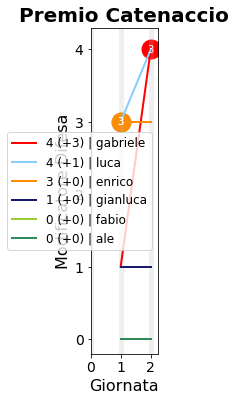

In [33]:
premio_plot(par='mod_difesa', threshold=2, title='Premio Catenaccio', ylabel='Modificatore Difesa') 

# [>] Box plots

In [34]:
###--- Melt dataframe with variables of interest ######################
def melt_df(variables = ['punti_subiti', 'punti_fatti']):
    data = []
    for team, df in Results.items():
        dd = pd.DataFrame()
        dd['Team'] = df['Team']
        for key in variables:
            dd[key] = df[key]
        data.append(dd)
    cdf = pd.concat(data)    
    mdf = pd.melt(cdf, id_vars=['Team'], var_name=['Variable'])
    return mdf

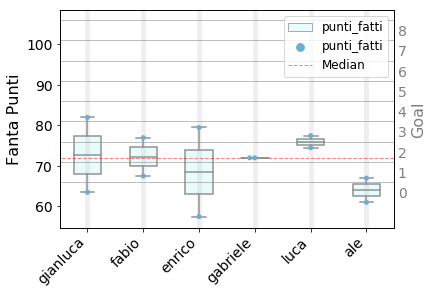

In [35]:
### Box plot ##############################
data = melt_df(['punti_fatti'])

# box plot
ax = sns.boxplot(x="Team", y="value", hue="Variable", data=data, color='cyan', whis=1.5, width=0.5)    
# draw single datapoints
ax = sns.swarmplot(x="Team", y="value", hue="Variable", data=data, palette="Blues")    

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#ax.set_ylim(-2,16)
ax.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
ax.hlines(goal_marks, -1000,1000, 'grey','-', linewidth=1, alpha=0.5)
ax.hlines(ps_med,-100,100, colors='red', linewidth=1, linestyles='--', alpha=0.5, label='Median')


ax.set_ylabel('Fanta Punti')
ax.set_xlabel('')
ax.legend()

# secondary y axis
ax2 = ax.twinx()
goal = lambda fp: (fp-66)/step + 0.5 
ymin, ymax = ax.get_ylim()
ax2.set_ylim((goal(ymin),goal(ymax)))
ax2.set_yticks([0,1,2,3,4,5,6,7,8])
ax2.set_ylabel('Goal')
ax2.tick_params(axis='y', colors='grey', length=0)
ax2.yaxis.label.set_color('grey')
ax2.plot([],[])

plt.show()

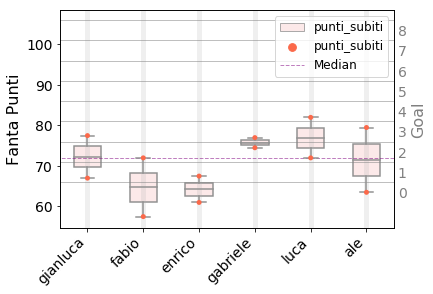

In [36]:
### Box plot ##############################
data = melt_df(['punti_subiti'])

# box plot
ax = sns.boxplot(x="Team", y="value", hue="Variable", data=data, color='r', whis=1.5, width=0.5)    
# draw single datapoints
ax = sns.swarmplot(x="Team", y="value", hue="Variable", data=data, palette="Reds")    

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#ax.set_ylim(-2,16)
ax.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
ax.hlines(goal_marks, -1000,1000, 'grey','-', linewidth=1, alpha=0.5)
ax.hlines(ps_med,-100,100, colors='purple', linewidth=1, linestyles='--', alpha=0.5, label='Median')


ax.set_ylabel('Fanta Punti')
ax.set_xlabel('')
ax.legend()

# secondary y axis
ax2 = ax.twinx()
goal = lambda fp: (fp-66)/step + 0.5 
ymin, ymax = ax.get_ylim()
ax2.set_ylim((goal(ymin),goal(ymax)))
ax2.set_yticks([0,1,2,3,4,5,6,7,8])
ax2.set_ylabel('Goal')
ax2.tick_params(axis='y', colors='grey', length=0)
ax2.yaxis.label.set_color('grey')
ax2.plot([],[])

plt.show()

# [>] Scores sotto la media

In [37]:
def print_low_scoring_results():
    for team, df in Results.items():
        print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if ((df['punti_fatti'][gg]<pf_med) & (df['punti_fatti'][gg]>=low_score)):
                res = esito(df.GF[gg], df.GS[gg])
                print('G', gg, ':', df.punti_fatti[gg], '|', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        print('--->', pti, 'punti in', g, 'giornate ( media:', pti/g,')')
        
        
def print_very_low_scoring_results():
    for team, df in Results.items():
        print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if df['punti_fatti'][gg]<low_score:
                res = esito(df.GF[gg], df.GS[gg])
                print('G', gg, ':', df.punti_fatti[gg], '|', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        try:
            print('--->', pti, 'punti in', g, 'giornate ( media:', pti/g,')')
        except:
            print('No games <', low_score, '  fantapunti found')

In [38]:
print_low_scoring_results()


### gianluca ###
G 2 : 63.5 | S ( 0 - 1 )
---> 0 punti in 1 giornate ( media: 0.0 )

### fabio ###
G 2 : 67.5 | V ( 2 - 0 )
---> 3 punti in 1 giornate ( media: 3.0 )

### enrico ###


ZeroDivisionError: division by zero

In [39]:
print_very_low_scoring_results()


### gianluca ###
No games < 62   fantapunti found

### fabio ###
No games < 62   fantapunti found

### enrico ###
G 2 : 57.5 | S ( 0 - 2 )
---> 0 punti in 1 giornate ( media: 0.0 )

### gabriele ###
No games < 62   fantapunti found

### luca ###
No games < 62   fantapunti found

### ale ###
G 1 : 61 | S ( 0 - 3 )
---> 0 punti in 1 giornate ( media: 0.0 )


In [40]:
def print_1GF_results():
    for team, df in Results.items():
        print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if df['GF'][gg] == 1:
                res = esito(df.GF[gg], df.GS[gg])
                print('G', gg, ':', df.punti_fatti[gg], '|', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        try:
            print('--->', pti, 'punti in', g, 'giornate ( media:', pti/g,')')
        except: 
            print('No games found with GF=1')

In [41]:
print_1GF_results()


### gianluca ###
No games found with GF=1

### fabio ###
No games found with GF=1

### enrico ###
No games found with GF=1

### gabriele ###
No games found with GF=1

### luca ###
No games found with GF=1

### ale ###
G 2 : 67 | V ( 1 - 0 )
---> 3 punti in 1 giornate ( media: 3.0 )


# [>] Andamento punti fatti/subiti

C:\Users\Luca\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


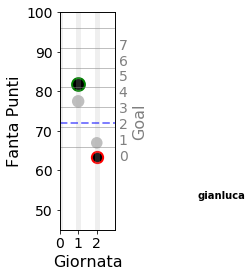

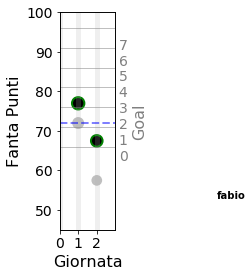

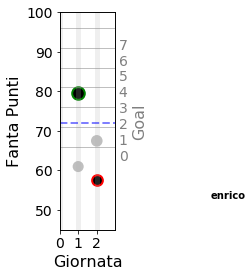

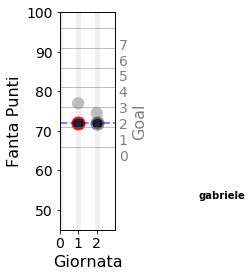

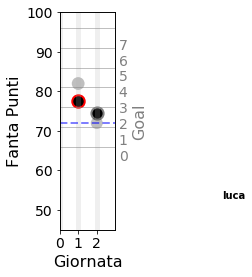

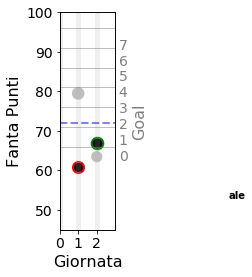

In [42]:
### Andamento per squadra ######################################################
for team in Results.keys(): 
    data = Results[team]
    gg = max(data.index)
    
    fig = plt.figure(figsize=(gg*0.5,4))

    plt.hlines(goal_marks, -1000,1000, 'grey','-', linewidth=1, alpha=0.5)
    #plt.axhspan(pf_med-2*pf_std, pf_med+2*pf_std, 0, 40, color='blue', alpha=0.05, label='$2\sigma$')
    #plt.axhspan(pf_med-1*pf_std, pf_med+1*pf_std, 0, 40, color='blue', alpha=0.1, label='$1\sigma$')
    plt.hlines(pf_med,0,40, colors='blue', linewidth=2, linestyles='--', alpha=0.5, label='Median')

    #ax = plt.scatter(data.index, data['punti_subiti'], c='blue', s=data['punti_subiti'], alpha=0.1)
    data = Results[team][Results[team].esito=='S']
    ax = plt.scatter(data.index, data['punti_fatti'], c='black', edgecolor='r', linewidth=2, s=data['punti_fatti']*2, label='')
    ax = plt.scatter(data.index, data['punti_subiti'], c='black', edgecolor='none', s=data['punti_subiti']*2, alpha=0.25, label='')
    data = Results[team][Results[team].esito=='P']
    ax = plt.scatter(data.index, data['punti_fatti'], c='black', edgecolor='grey', linewidth=2, s=data['punti_fatti']*2, label='')
    ax = plt.scatter(data.index, data['punti_subiti'], c='black', edgecolor='none', s=data['punti_subiti']*2, alpha=0.25, label='')
    data = Results[team][Results[team].esito=='V']
    ax = plt.scatter(data.index, data['punti_fatti'], c='black', edgecolor='g', linewidth=2, s=data['punti_fatti']*2, label='')
    ax = plt.scatter(data.index, data['punti_subiti'], c='black', edgecolor='none', s=data['punti_subiti']*2, alpha=0.25, label='')

    plt.xlabel('Giornata')
    plt.ylabel('Fanta Punti')
    plt.text(10,53,team, horizontalalignment='right', fontweight='1000')

    giornata=gg+1
    ymin = 45
    ymax = 100
    plt.xlim(0,giornata)
    plt.ylim(ymin, ymax)
    plt.xticks(np.arange(0,giornata))
    plt.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
    #plt.minorticks_on()
    
    # secondary y axis
    ax2 = plt.twinx()
    goal = lambda fp: (fp-66)/4 + 0.5 
    #ymin, ymax = plt.axes.get_ylim()
    ax2.set_ylim((goal(ymin),goal(ymax)))
    ax2.set_yticks([0,1,2,3,4,5,6,7])
    ax2.set_ylabel('Goal')
    ax2.tick_params(axis='y', colors='grey', length=0)
    ax2.yaxis.label.set_color('grey')
    ax2.plot([],[])
  
    plt.show()

In [43]:
Tot_per_round[0].keys()

Index(['punti_fatti', 'punti_subiti', 'goal_subiti_por', 'cartellini',
       'mod_difesa', 'GF', 'GS', 'esito', 'pti', 'Team', 'f_close_games',
       'f_media_giornata', 'f_media_personale', 'pos', 'rank', 'distacco',
       'f_pos', 'f_distacco', 'x_punti_subiti', 'x_GS', 'f_GS',
       'IndiceFortuna'],
      dtype='object')

In [44]:
data = Tot_per_round[0]
xxx = pd.DataFrame()
for key in Tot_per_round[0].keys():
    xxx[key] = data[key]
xxx

,punti_fatti,punti_subiti,goal_subiti_por,cartellini,mod_difesa,GF,GS,esito,pti,Team,...,f_media_personale,pos,rank,distacco,f_pos,f_distacco,x_punti_subiti,x_GS,f_GS,IndiceFortuna
0,82.0,77.5,1,1,1,4,3,V,3,gianluca,...,0.0,1.0,1.0,0,0.0,0.309990,73.4,2.2,-0.635776,0.2
1,77.0,72.0,3,3,0,3,2,V,3,fabio,...,0.0,3.0,4.0,0,1.0,1.036316,74.4,2.4,0.317888,1.4
2,79.5,61.0,1,2,3,3,0,V,3,enrico,...,0.0,2.0,2.0,0,0.0,0.673153,73.9,2.4,1.907327,1.4
3,72.0,77.0,0,1,1,2,3,S,0,gabriele,...,0.0,5.0,5.0,3,0.0,-0.237357,75.4,2.6,-0.317888,-0.6
4,77.5,82.0,0,1,3,3,4,S,0,luca,...,0.0,4.0,3.0,3,-1.0,-1.036316,74.3,2.4,-1.271551,-1.7
5,61.0,79.5,2,1,0,0,3,S,0,ale,...,0.0,6.0,6.0,3,0.0,1.360560,77.6,3.0,-0.000000,0.0


## Distribuzione goal / Poisson?

(array([56., 72., 75., 40., 14.,  5.,  2.]),
 array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <a list of 7 Patch objects>)

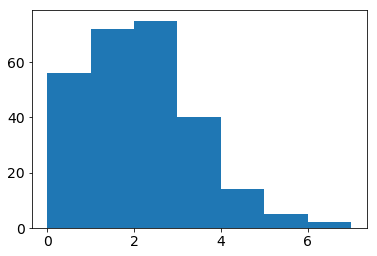

In [41]:
goal_made=cdf[['GF']]
#goal_made['GF'].describe()
#plt.figure()
plt.hist(goal_made['GF'],7)

(array([56., 72., 75., 40., 14.,  5.,  2.]),
 array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <a list of 1 Patch objects>)

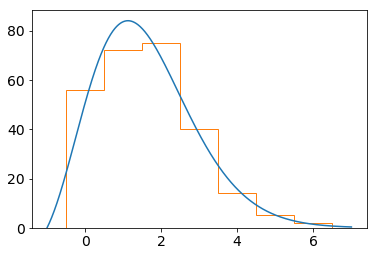

In [42]:
average=goal_made['GF'].mean()
total=giornate*n_giocatori
import scipy.special
x=np.arange(-1,7.01,0.01)
plt.plot(x, total*np.exp(-average)*average**x/scipy.special.gamma(x+1))
plt.hist(goal_made['GF'],7,align='left',rwidth=0.1,histtype='step')

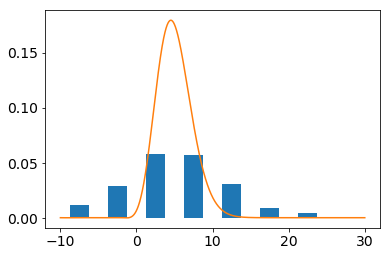

In [43]:
plt.hist(cdf['punti_fatti']-66,range=(-10,30),bins=8,rwidth=0.5,density=True)
av=cdf['punti_fatti'].mean()-66
x=np.arange(-10,30.01,0.01)
plt.plot(x, np.exp(-av)*av**(x)/scipy.special.gamma((x)+1))

In [44]:
cdf['punti_fatti'].describe()

count    264.000000
mean      71.026515
std        7.200236
min       44.500000
25%       66.875000
50%       71.000000
75%       75.000000
max       98.500000
Name: punti_fatti, dtype: float64

In [45]:
cdf['punti_fatti'].mean()-cdf['punti_fatti'].std()

63.826278993067845

In [46]:
cdf['punti_fatti'].std()

7.200236158447314